In [1]:
%load_ext autoreload
%load_ext memory_profiler
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Seaborn enhances the aesthetics of matplotlib plots
import pandas as pd
import xarray as xr

from tempest import casestudy
from tempest import grid
from tempest import storm_tracker
from tempest import joint_distrib
from tempest import handler
from tempest.plots.hist import simple_hist
settings_path = 'settings/tropics_20d.yaml'

In [3]:
## Load handler and pass settings
hdlr = handler.Handler(settings_path)

## Initiate variables
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)

## Make grid and load data on grid 
gr = grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False)

## Get ocean mask 
lm = gr.get_landmask()
ocean = lm.Landmask == 0
ocean = ocean.values[:,:,np.newaxis]

## Load storms 
st = storm_tracker.StormTracker(gr, label_var_id = "MCS_label", overwrite = False)

##
jd = joint_distrib.JointDistribution(gr, st, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_50_Prec", nd=5, overwrite = True, dist_mask = ocean)

Data loaded from /scratchx/mcarenso/tempest/DYAMOND_SAM_post_20_days_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /scratchx/mcarenso/tempest/DYAMOND_SAM_post_20_days_Tropics/grid_attributes.pkl instead of computing
Creating Earth (rough borders)


PermissionError: [Errno 13] Permission denied: '/scratchx/mcarenso/tempest/DYAMOND_SAM_post_20_days_Tropics/landmask.nc'

## Func that makes mask

In [ ]:
def make_region_mask(min_lat, max_lat, min_lon, max_lon, pre_mask = True):
    array_shape = (60, 360, 20)
    # Combine the masks along each dimension
    mask = np.zeros(array_shape, dtype=bool)
    mask[min_lat+30:max_lat+30, min_lon:max_lon, :] = True
    mask = np.logical_and(mask, pre_mask)
    return mask

warmpool = make_region_mask(0, 25, 100, 195, pre_mask = ocean)
atlantic_itcz = make_region_mask(0, 20, 290, 345, pre_mask = ocean)

## Convective genesis
east_indian_ocean = make_region_mask(-10, 5, 85, 103, pre_mask = ocean)
central_america = make_region_mask(5, 20, 260, 285, pre_mask = ocean)
east_dipole_side = np.logical_or(east_indian_ocean, central_america)

## Stratiform region
west_indian_ocean = make_region_mask(-10, 10, 55, 85, pre_mask = ocean)
pacific_itcz = make_region_mask(0, 25, 195, 260, pre_mask = ocean)
west_dipole_side = np.logical_or(west_indian_ocean, pacific_itcz)

## Bincount map per category

figure size = 15 3.25
figure size = 15 3.25


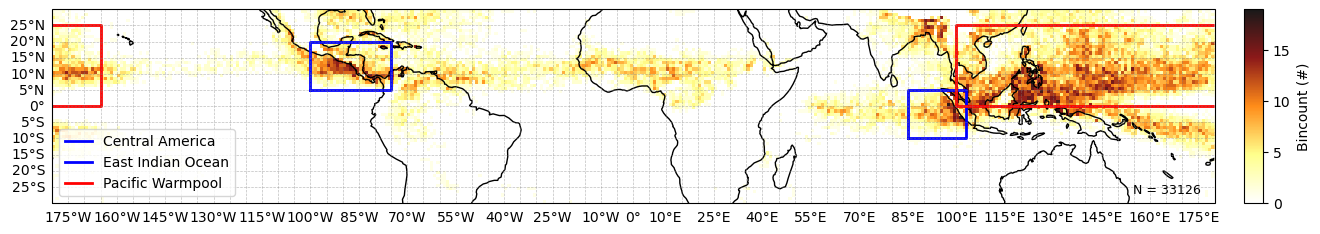

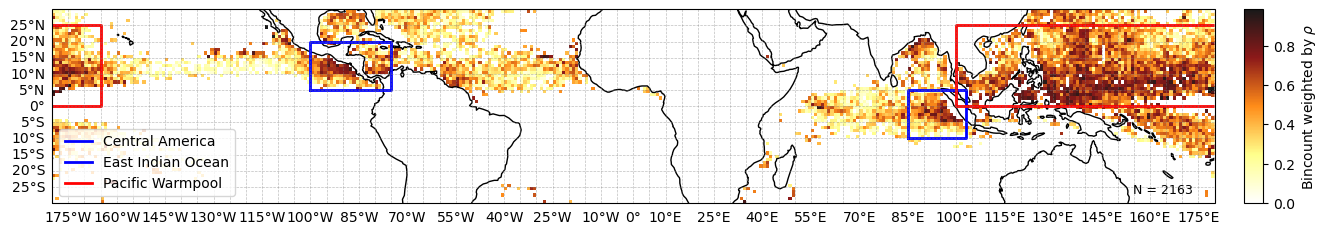

In [ ]:
import cartopy.crs as ccrs
import os 
%matplotlib inline
# Show frequency maps of extremes in the 4 regions (normalized by total bincount in mask?)

jd.make_mask()

mask_all = [jd.mask_coloc_c_90, jd.mask_coloc_c_90]
mask_names = ['Mostly km-scale', r'Mostly km-scale weighted by $\rho$'] 
mask_labels = 'mostlykm','mostlykm_weighted'
figdir = ''

threshold = jd.prec.Treshold_cond_alpha_50_Prec.values
# sigma = jd.prec.Sigma_cond_alpha_50_Prec.values

for mask, mask_name, mask_label, data in zip(mask_all, mask_names, mask_labels, [None, threshold]):

    mask_yxt = jd.get_mask_yxt_from_mask_jdist(mask)
    mask_yxt_ocean = np.logical_and(mask_yxt, ocean)

    if data is None : 
        ax, cbar = jd.make_map(mask_yxt, data = None)
    else : 
        ax, cbar = jd.make_map(mask_yxt_ocean, data = data, func='data_weighted')
        cbar.set_label(r"Bincount weighted by $\rho$")

    ## Central America 
    lon_min, lon_max = 260, 285 #gr.lon_slice.start , gr.lon_slice.stop
    lat_min, lat_max = 5, 20#gr.lat_slice.start, gr.lat_slice.stop
    ax.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
                [lat_min, lat_min, lat_max, lat_max, lat_min],
                color='b', linestyle='-', linewidth=2, transform=ccrs.PlateCarree(), label = "Central America")

    ## East Indian Ocean 
    lon_min, lon_max = 85, 103 #gr.lon_slice.start , gr.lon_slice.stop
    lat_min, lat_max = -10, 5 #gr.lat_slice.start, gr.lat_slice.stop
    ax.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
                [lat_min, lat_min, lat_max, lat_max, lat_min],
                color='b', linestyle='-', linewidth=2, transform=ccrs.PlateCarree(), label = "East Indian Ocean")
    
    ## Pacific Warmpool + South East Asia Lands
    lon_min, lon_max = 100, 195 #gr.lon_slice.start , gr.lon_slice.stop
    lat_min, lat_max = 0, 25#gr.lat_slice.start, gr.lat_slice.stop
    ax.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
                [lat_min, lat_min, lat_max, lat_max, lat_min],
                color='r', linestyle='-', linewidth=2, transform=ccrs.PlateCarree(), label = "Pacific Warmpool")
    
    ax.legend()
    
    # ax.set_title(mask_name)
    plt.savefig(os.path.join(figdir,'map_bincount_%s_extremes.png'%(mask_label)),bbox_inches='tight')
    plt.savefig(os.path.join(figdir,'map_bincount_%s_extremes.png'%(mask_label)),bbox_inches='tight')

figure size = 15 3.25
figure size = 15 3.25


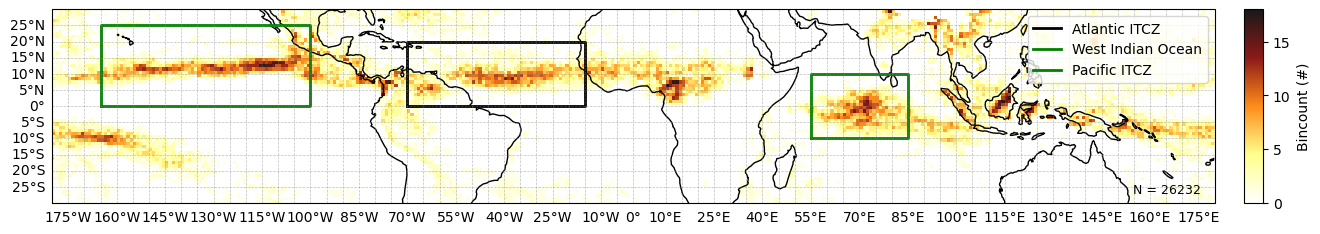

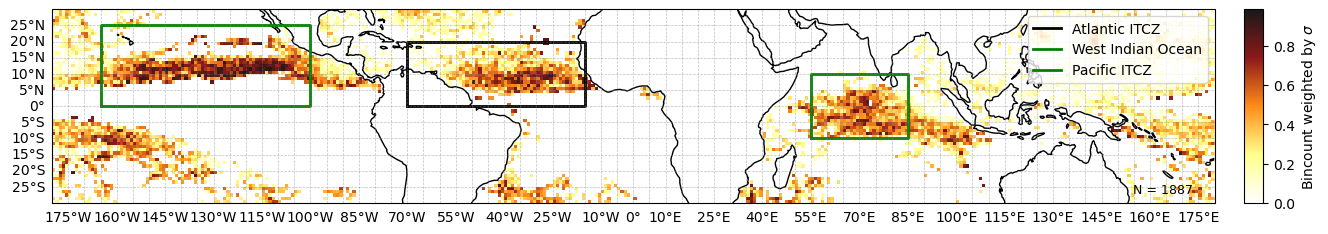

In [ ]:
import cartopy.crs as ccrs
import os 
%matplotlib inline

mask_all = [jd.mask_coloc_ac_90, jd.mask_coloc_ac_90]
mask_names = ['Mostly coarse-grained', r'Mostly coarse-grained weighted by $\sigma$']
mask_labels = 'mostlycg','mostlycg_weighted'
figdir = ''

sigma = jd.prec.Sigma_cond_alpha_50_Prec.values

data = [None, sigma]

for mask, mask_name, mask_label, data in zip(mask_all, mask_names, mask_labels, [None, threshold]):

    mask_yxt = jd.get_mask_yxt_from_mask_jdist(mask)
    mask_yxt_ocean = np.logical_and(mask_yxt, ocean)

    if data is None : 
        ax, cbar = jd.make_map(mask_yxt, data = None)
    else : 
        ax, cbar = jd.make_map(mask_yxt_ocean, data = data, func='data_weighted')
        cbar.set_label(r"Bincount weighted by $\sigma$")

    
    ## Atlantic ITCZ
    lon_min, lon_max = 290, 345 #gr.lon_slice.start , gr.lon_slice.stop
    lat_min, lat_max = 0, 20 #gr.lat_slice.start, gr.lat_slice.stop
    ax.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
                [lat_min, lat_min, lat_max, lat_max, lat_min],
                color='k', linestyle='-', linewidth=2, transform=ccrs.PlateCarree(), label = "Atlantic ITCZ")
    
    ## West Indian Ocean 
    lon_min, lon_max = 55, 85 #gr.lon_slice.start , gr.lon_slice.stop
    lat_min, lat_max = -10, 10 #gr.lat_slice.start, gr.lat_slice.stop
    ax.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
                [lat_min, lat_min, lat_max, lat_max, lat_min],
                color='g', linestyle='-', linewidth=2, transform=ccrs.PlateCarree(), label = "West Indian Ocean")
    
    ## Pacific ITCZ
    lon_min, lon_max = 195, 260 #gr.lon_slice.start , gr.lon_slice.stop
    lat_min, lat_max = 0, 25 #gr.lat_slice.start, gr.lat_slice.stop
    ax.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
                [lat_min, lat_min, lat_max, lat_max, lat_min],
                color='g', linestyle='-', linewidth=2, transform=ccrs.PlateCarree(), label = "Pacific ITCZ")

    ax.legend()
    
    plt.savefig(os.path.join(figdir,'map_bincount_%s_extremes.png'%(mask_label)),bbox_inches='tight')
    plt.savefig(os.path.join(figdir,'map_bincount_%s_extremes.png'%(mask_label)),bbox_inches='tight')

## Stack bar chart

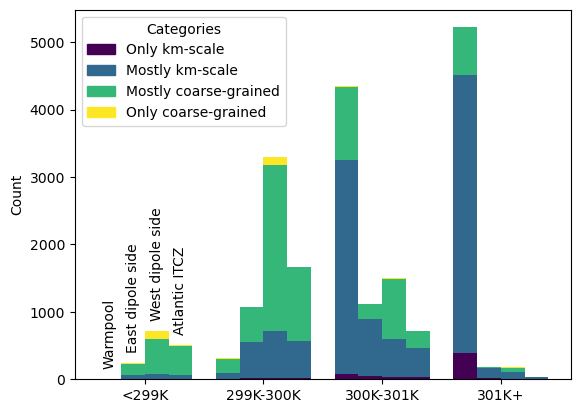

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib as mpl

temp_ds = gr.get_var_id_ds("T2mm")
temp = temp_ds.mean_T2mm.values

var_days = list(temp_ds.days.values)  
prec_days = list(jd.prec.days.values)  
days_filter = np.array([prec_day in var_days for prec_day in prec_days])

mask_all = [jd.mask_branch1_90, jd.mask_coloc_c_90, jd.mask_coloc_ac_90, jd.mask_branch2_90]

# Defining temperature bins
bins = [0, 299, 300, 301, np.inf]
bin_labels = ['<299K', '299K-300K', '300K-301K', '301K+']
mask_categories_yxt = [jd.get_mask_yxt_from_mask_jdist(mask)[:,:,days_filter] for mask in mask_all]

# Calculate counts for each category within each bin for original categories
count_matrix = np.zeros((len(bins) - 1, len(mask_categories_yxt)))
for i, mask in enumerate(mask_categories_yxt):
    masked_temp = np.where(mask, temp, np.nan)
    for j in range(len(bins) - 1):
        bin_mask = np.logical_and(masked_temp >= bins[j], masked_temp < bins[j + 1])
        count_matrix[j, i] = np.nansum(bin_mask)

# ocean categories
ocean_mask_categories_yxt_unfiltered = [warmpool, east_dipole_side, west_dipole_side, atlantic_itcz]
ocean_mask_categories_yxt = [ocean_mask[:,:,days_filter] for ocean_mask in ocean_mask_categories_yxt_unfiltered]
ocean_categories_count = len(ocean_mask_categories_yxt)

# Calculate counts for each ocean category within each bin
ocean_count_matrix = np.zeros((len(bins) - 1, ocean_categories_count))
for i, mask in enumerate(ocean_mask_categories_yxt):
    masked_temp = np.where(mask, temp, np.nan)
    for j in range(len(bins) - 1):
        bin_mask = np.logical_and(masked_temp >= bins[j], masked_temp < bins[j + 1])
        ocean_count_matrix[j, i] = np.nansum(bin_mask)

# Set up the colormap and normalizer
cmap = mpl.cm.viridis
norm = mpl.colors.BoundaryNorm(np.arange(0.5, 5), cmap.N)

# Plotting adjusted to have SST bins on the x-axis, with each bar representing an ocean, and stacks within each bar for categories
fig, ax = plt.subplots()

# Number of SST bins
n_bins = len(bins) - 1

# Positions for the SST bins on the x-axis
bin_positions = np.arange(n_bins)

# Width of each set of bars within a bin
group_width = 0.8 / ocean_categories_count  # Divide the space within each bin equally among the oceans

first_group_ocean_bins = np.zeros(len(ocean_mask_categories_yxt))
# Looping through each SST bin to plot
for bin_idx, bin_position in enumerate(bin_positions):

    # Looping through each ocean category to plot bars side by side within the SST bin
    for ocean_idx, mask in enumerate(ocean_mask_categories_yxt):
        # Bottoms for stacking the category counts within this ocean's bar
        bottoms = np.zeros(n_bins)

        # Calculate position for this ocean's bar within the current SST bin
        ocean_bar_position = bin_position - 0.4 + (ocean_idx + 0.5) * group_width

        category_counts_in_bin = np.zeros(n_bins)
        # Loop through each original category to stack within the ocean's bar
        for category_idx, category_mask in enumerate(mask_categories_yxt):
            # Select color for this category
            color = cmap(norm(category_idx + 1))

            # Calculate counts for this category within the current SST bin and ocean
            masked_temp = np.where(category_mask & mask, temp, np.nan)  # Combine category and ocean masks
            bin_mask = np.logical_and(masked_temp >= bins[bin_idx], masked_temp < bins[bin_idx + 1])
            category_counts_in_bin[bin_idx] = np.nansum(bin_mask)

            # Plot the stack for this category within the ocean's bar, using the selected color
            ax.bar(ocean_bar_position, category_counts_in_bin[bin_idx], group_width, bottom=bottoms[bin_idx], color=color, label=f'Ocean {ocean_idx+1}, Category {category_idx+1}')
            bottoms[bin_idx] += category_counts_in_bin[bin_idx]

            if bin_idx == 0 : first_group_ocean_bins[ocean_idx]+= np.sum(category_counts_in_bin)

# Categories legend
categories = ['Only km-scale', 'Mostly km-scale', 'Mostly coarse-grained', 'Only coarse-grained']
category_patches = [mpl.patches.Patch(color=cmap(norm(category_idx + 1)), label=categories[category_idx]) for category_idx in range(4)]
ax.legend(handles=category_patches, loc='upper left', title='Categories')

oceans = ['Warmpool', 'East dipole side', 'West dipole side', 'Atlantic ITCZ']
# Add labels on top of the first group of stacked bars
for ocean_idx, mask in enumerate(ocean_mask_categories_yxt):
    # Calculate the x position for the label. It should be at the center of the ocean's bar in the first SST bin
    label_x_position = bin_positions[0] - 0.4 + (ocean_idx + 0.5) * group_width

    # Calculate the y position for the label. It should be slightly above the top of the highest stack in the first SST bin for this ocean
    # Assuming 'total_counts_per_ocean_bin' is an array holding the total counts for each ocean in each bin
    label_y_position = first_group_ocean_bins[ocean_idx] + 200  # 'some_offset' is a small number to position the label above the bar

    # Add the label using ax.text ()
    ax.text(label_x_position, label_y_position, oceans[ocean_idx], ha='center', rotation=90)

# Finalizing the plot
ax.set_xticks(bin_positions)
ax.set_xticklabels(bin_labels)
ax.set_ylabel('Count')
# ax.set_title('Temperature Bin Distribution by Ocean and Category')

plt.savefig(os.path.join('','Temp_bin_distrib_by_cat_and_ocean'),bbox_inches='tight')
plt.show()

In [ ]:
first_group_ocean_bins

array([9887., 2677., 5686., 2923.])

# T2mm

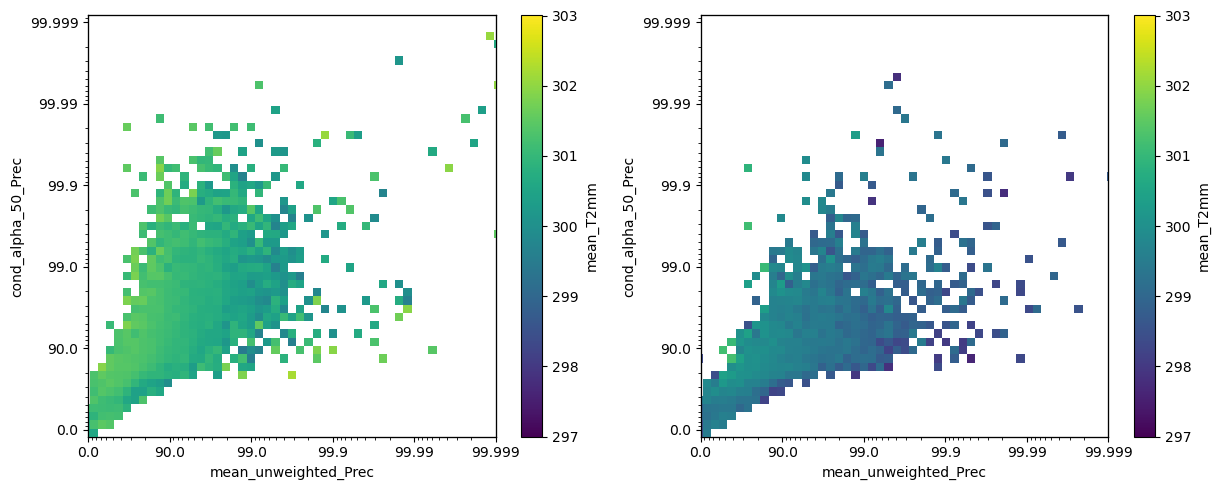

In [8]:
fig, axs = plt.subplots(1, 2, figsize = (12.4, 5))

var_id = "T2mm"
func = 'mean' 
vbds = (297, 303)
jd.plot_var_id_func_over_jdist(var_id=var_id, func=func, mask = warmpool, vbds = vbds, fig = fig, ax = axs[0])
jd.plot_var_id_func_over_jdist(var_id=var_id, func=func, mask = west_indian_ocean, vbds= vbds,  fig = fig, ax = axs[1])
plt.tight_layout()

# QV* 2d

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (12.4, 5))

var_id = "QV_sat_2d"
func = 'mean' 
vbds = (0.018, 0.025)
jd.plot_var_id_func_over_jdist(var_id=var_id, func=func, mask = warmpool, vbds = vbds, fig = fig, ax = axs[0])
jd.plot_var_id_func_over_jdist(var_id=var_id, func=func, mask = west_indian_ocean, vbds = vbds, fig = fig, ax = axs[1])
plt.tight_layout()

## Stack bar chart

In [22]:
temp = gr.get_var_id_ds("T2mm").mean_T2mm
mask_categories_yxt = [jd.get_mask_yxt_from_mask_jdist(mask_ranked)[:,:,-14:] for mask_ranked in mask_rank_all] # only 14 days in T2mm

In [23]:
temp.values

array([[[290.1340314 , 289.92854333, 289.86674799, ..., 288.50158211,
         287.48078252, 287.96413914],
        [290.11255783, 289.82032515, 289.8113897 , ..., 288.60414967,
         287.43696684, 287.71234728],
        [290.0711754 , 289.72603713, 289.74308733, ..., 288.53273452,
         287.38658329, 287.41424622],
        ...,
        [289.90211142, 289.67429934, 289.64660106, ..., 288.68797053,
         287.49159248, 288.59602659],
        [290.02050361, 289.7932977 , 289.7549198 , ..., 288.83012707,
         287.4964568 , 288.40987423],
        [290.18673735, 289.96699336, 289.86986559, ..., 288.71131133,
         287.47478304, 288.18334515]],

       [[290.4411852 , 290.13458162, 290.21970986, ..., 289.29088329,
         288.02608642, 288.08587035],
        [290.35325221, 290.01465923, 290.06725717, ..., 289.21867988,
         287.9562066 , 287.76082296],
        [290.13738767, 289.85842922, 289.71985407, ..., 288.86407145,
         287.80603876, 287.43146922],
        ...,


## storm attr from MCS_label.nc

In [12]:
def custom_nan_percentile(arr, q):
    """
    Calculate the q-th percentile of the given array, handling NaN values.

    Parameters:
        arr (array-like): Input array.
        q (float): Percentile to compute (between 0 and 100).

    Returns:
        float: The q-th percentile of the array.
    """
    # Filter out NaN values
    non_nan_values = arr[~np.isnan(arr)]
    
    # Check if there are no non-NaN values
    if len(non_nan_values) == 0:
        return np.nan
    
    # Calculate the percentile
    return np.percentile(non_nan_values, q)

In [9]:
mcs = gr.get_var_id_ds("MCS_label")
mcs

<xarray.Dataset>
Dimensions:                         (lat_global: 60, lon_global: 360, days: 20,
                                     MCS: 300)
Coordinates:
  * lat_global                      (lat_global) float64 -29.5 -28.5 ... 29.5
  * lon_global                      (lon_global) float64 0.5 1.5 ... 358.5 359.5
  * days                            (days) object '16-08-21' ... '16-09-09'
  * MCS                             (MCS) int64 0 1 2 3 4 ... 296 297 298 299
Data variables:
    global_pixel_surf               (lat_global, lon_global, days) float64 ...
    MCS_label                       (lat_global, lon_global, days, MCS) float64 ...
    Rel_surface                     (lat_global, lon_global, days, MCS) float64 ...
    MCS_rel_occupation              (lat_global, lon_global, days) float64 ...
    max_MCS_rel_surf                (lat_global, lon_global, days) float64 ...
    avg_MCS_rel_surf                (lat_global, lon_global, days) float64 ...
    root_weight_avg_MCS_rel_surf    (lat_global, lon_global, days) float64 ...
    square_weight_avg_MCS_rel_surf  (lat_global, lon_global, days) float64 ...
    weight_avg_MCS_rel_surf         (lat_global, lon_global, days) float64 ...
    growth_rate                     (lat_global, lon_global, days) float64 ...
    olrmin_surf_fro_adj             (lat_global, lon_global, days) float64 ...

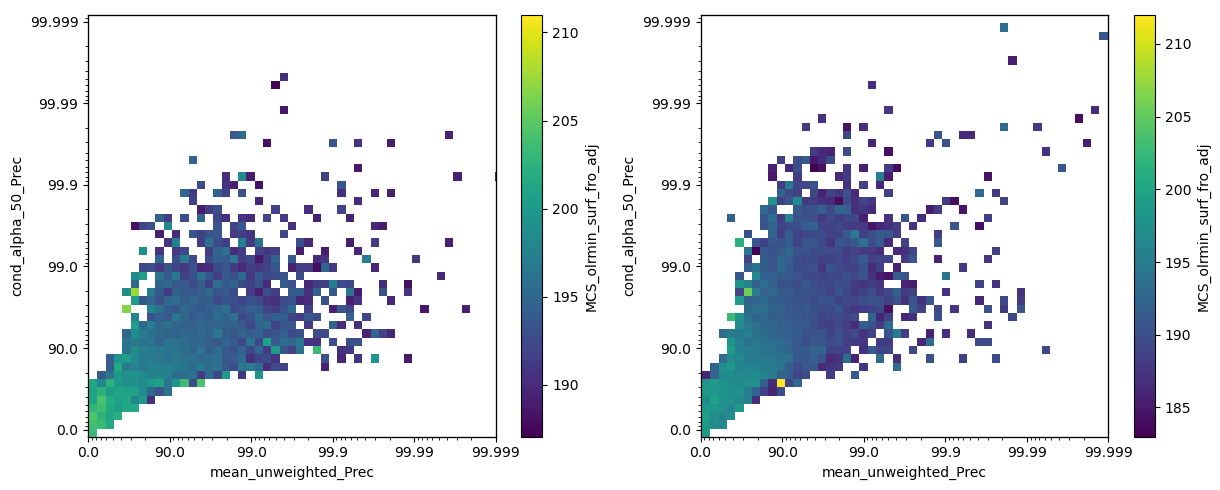

In [10]:
fig, axs = plt.subplots(1, 2, figsize = (12.4, 5))

var_id = "olrmin_surf_fro_adj"
func = 'MCS' 
jd.plot_var_id_func_over_jdist(var_id=var_id, func=func, mask = indian_ocean, plot_func = lambda x : custom_nan_percentile(x, 10) ,fig = fig, ax = axs[0])
jd.plot_var_id_func_over_jdist(var_id=var_id, func=func, mask = warmpool, plot_func = lambda x : custom_nan_percentile(x, 10), fig = fig, ax = axs[1])
plt.tight_layout()